In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import phate

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [5]:
with h5py.File(os.path.join(exp_path, fname), 'r') as hf:
    #model_attrs = hf['gradients'][:]
    #print('loaded gradient of fc1 w.r.t. input from {}'.format(attr_fc1_saliency_name))
    inputs = hf['inputs'][:]
    class_label_names = hf['class_label_names'][:]
    class_labels = hf['class_labels'][:]
    samples = hf['samples'][:]
    snp_names = hf['snp_names'][:]

In [6]:
label_with_names = [str(class_label_names[y])[2:-1] for y in class_labels]

In [7]:
label_with_superpop_names = np.zeros_like(label_with_names)
for label in mappings.super_pops_1000G:
    index = pd.DataFrame(label_with_names).isin(mappings.super_pops_1000G[label]).values.flatten()
    label_with_superpop_names[index] = label

In [8]:
def plot_embeddings_1000G_labels(emb, labels, palette, label_order, ax):
    
    sns.scatterplot(x=emb[:,0],
                    y=emb[:,1],
                    ax=ax,
                    palette=palette,
                    hue_order=label_order,
                    hue=pd.Categorical(labels))
    ax.legend(bbox_to_anchor=(1.1, 1.05), loc='upper left')

    for label in np.unique(labels):
        index = label == labels
        mean_pos = emb[index,:2].mean(0)
        ax.text(x=mean_pos[0], 
                y=mean_pos[1], 
                s=label)

## PHATE Defaults

Running PHATE on 2322 observations and 229986 variables.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 56.52 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.32 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 56.89 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.13 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.85 seconds.
Calculated landmark operator in 4.53 seconds.
Calculating optimal t...
  Automatically selected t = 6
Calculated optimal t in 1.77 seconds.


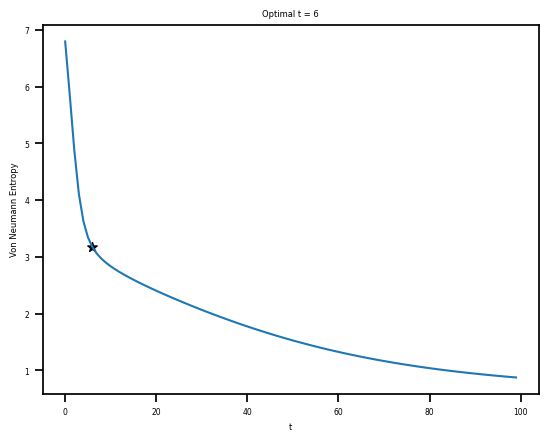

Calculating diffusion potential...
Calculated diffusion potential in 0.62 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.71 seconds.


In [9]:
# initial phate embedding
phate_operator42 = phate.PHATE(random_state=42)
phate_operator42.fit(inputs)
phate_emb42 = phate_operator42.transform(plot_optimal_t=True)

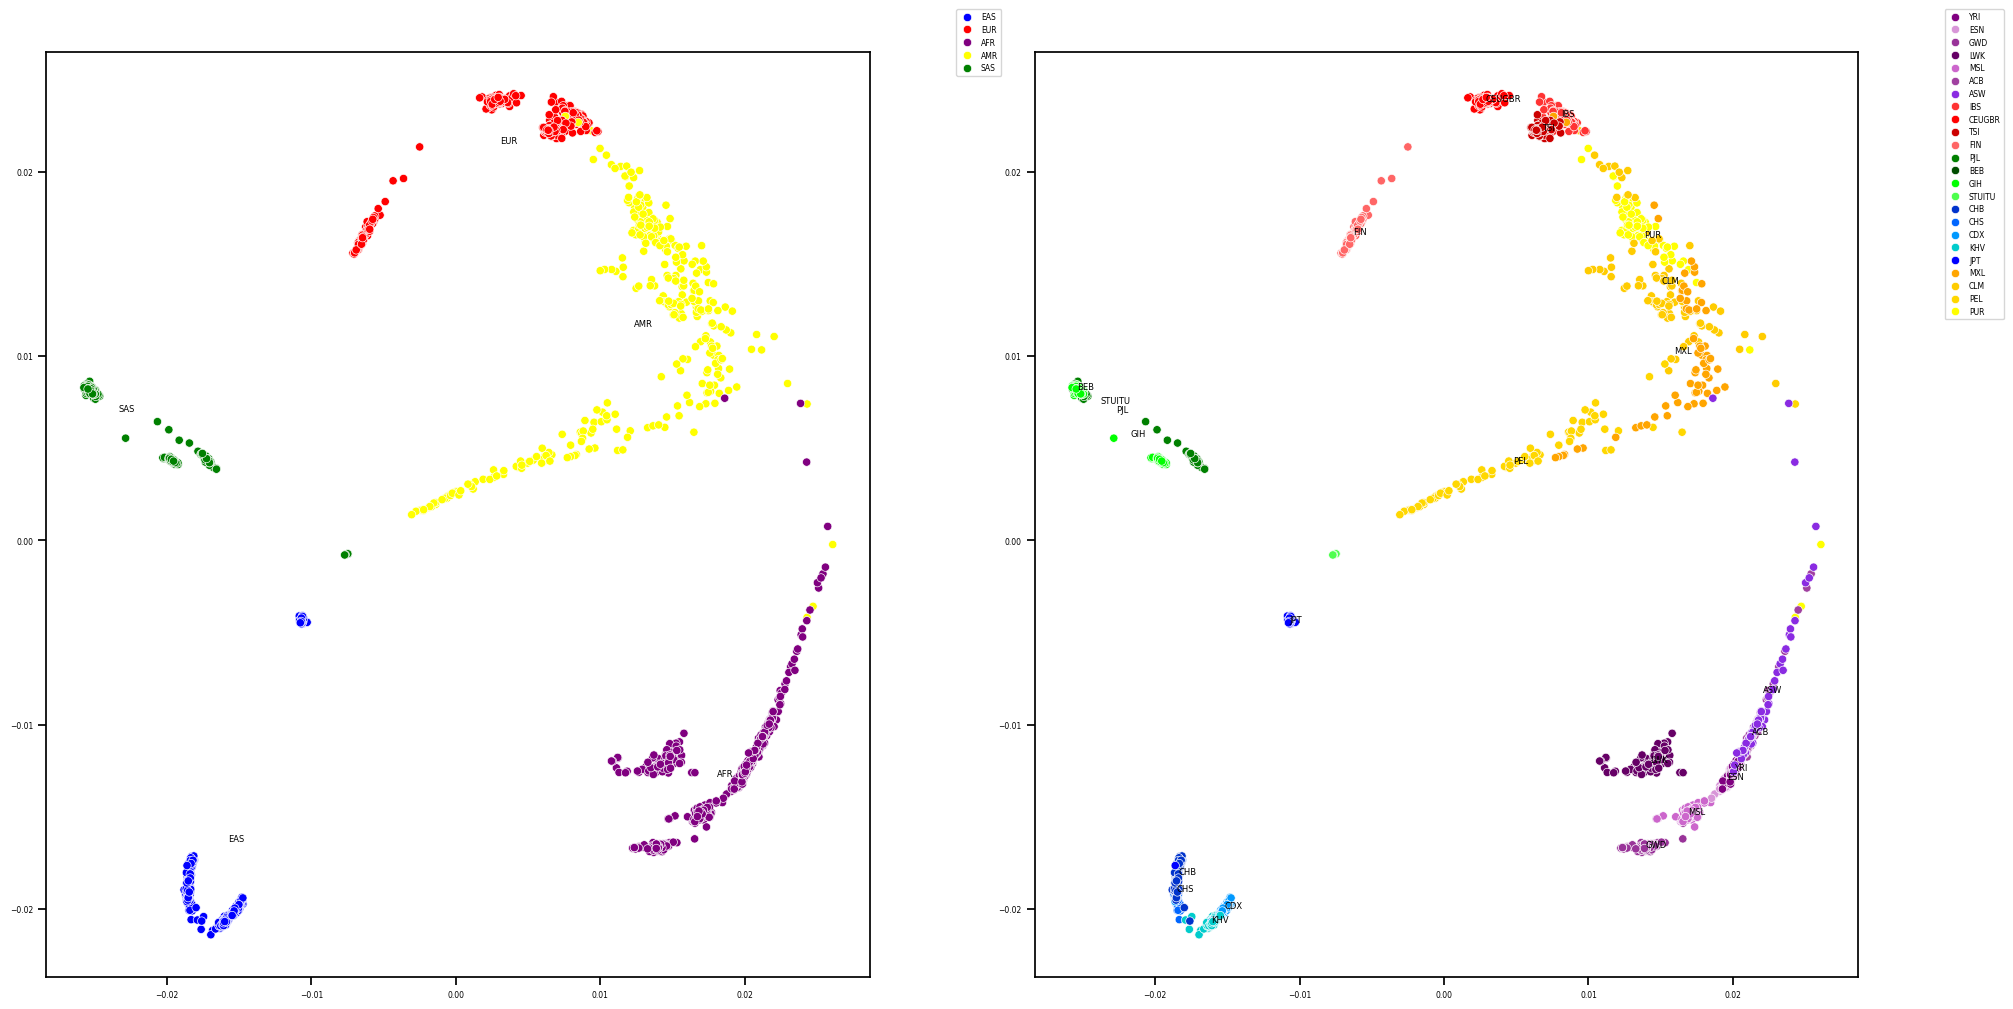

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
plot_embeddings_1000G_labels(phate_emb42, 
                             np.array(label_with_superpop_names), 
                             mappings.pop_pallette_1000G_coarse,
                             mappings.label_order_1000G_coarse,
                             ax[0])
plot_embeddings_1000G_labels(phate_emb42, 
                             np.array(label_with_names),
                             mappings.pop_pallette_1000G_fine,
                             mappings.label_order_1000G_fine,
                             ax[1])
plt.tight_layout()

## Load Admix from Paper

In [11]:
# load admix ratios
# Admix ratios from: https://github.com/diazale/topstrat/tree/main/data
sample_ids = pd.read_csv('notebooks/AdmixFromPaper/csa_ids.txt', sep=' ', header=None)
admix_ratios = pd.read_csv('notebooks/AdmixFromPaper/csa_1kgp.3.Q', sep=' ', header=None)

In [12]:
admix_df = pd.concat([admix_ratios, sample_ids], axis=1)
admix_df.columns = ['admix 1', 'admix 2', 'admix 3' , 'id 1', 'id 2', 'label']

In [13]:
admix_labels = np.zeros([len(label_with_names), 3])

In [14]:
labels2 = np.array([sample.decode("utf-8") for sample in samples])

In [15]:
matching_indices = np.array([np.where(admix_df['id 1'][j] == labels2)[0][0] if len(np.where(admix_df['id 1'][j] == labels2)[0]) > 0 else -1 for j in range(len(admix_df))])

In [16]:
for i, idx in enumerate(matching_indices):
    if idx != -1:
        admix_labels[idx] = admix_df.iloc[i].values[:3]

Text(0.5, 1.0, 'European ancestry (%)')

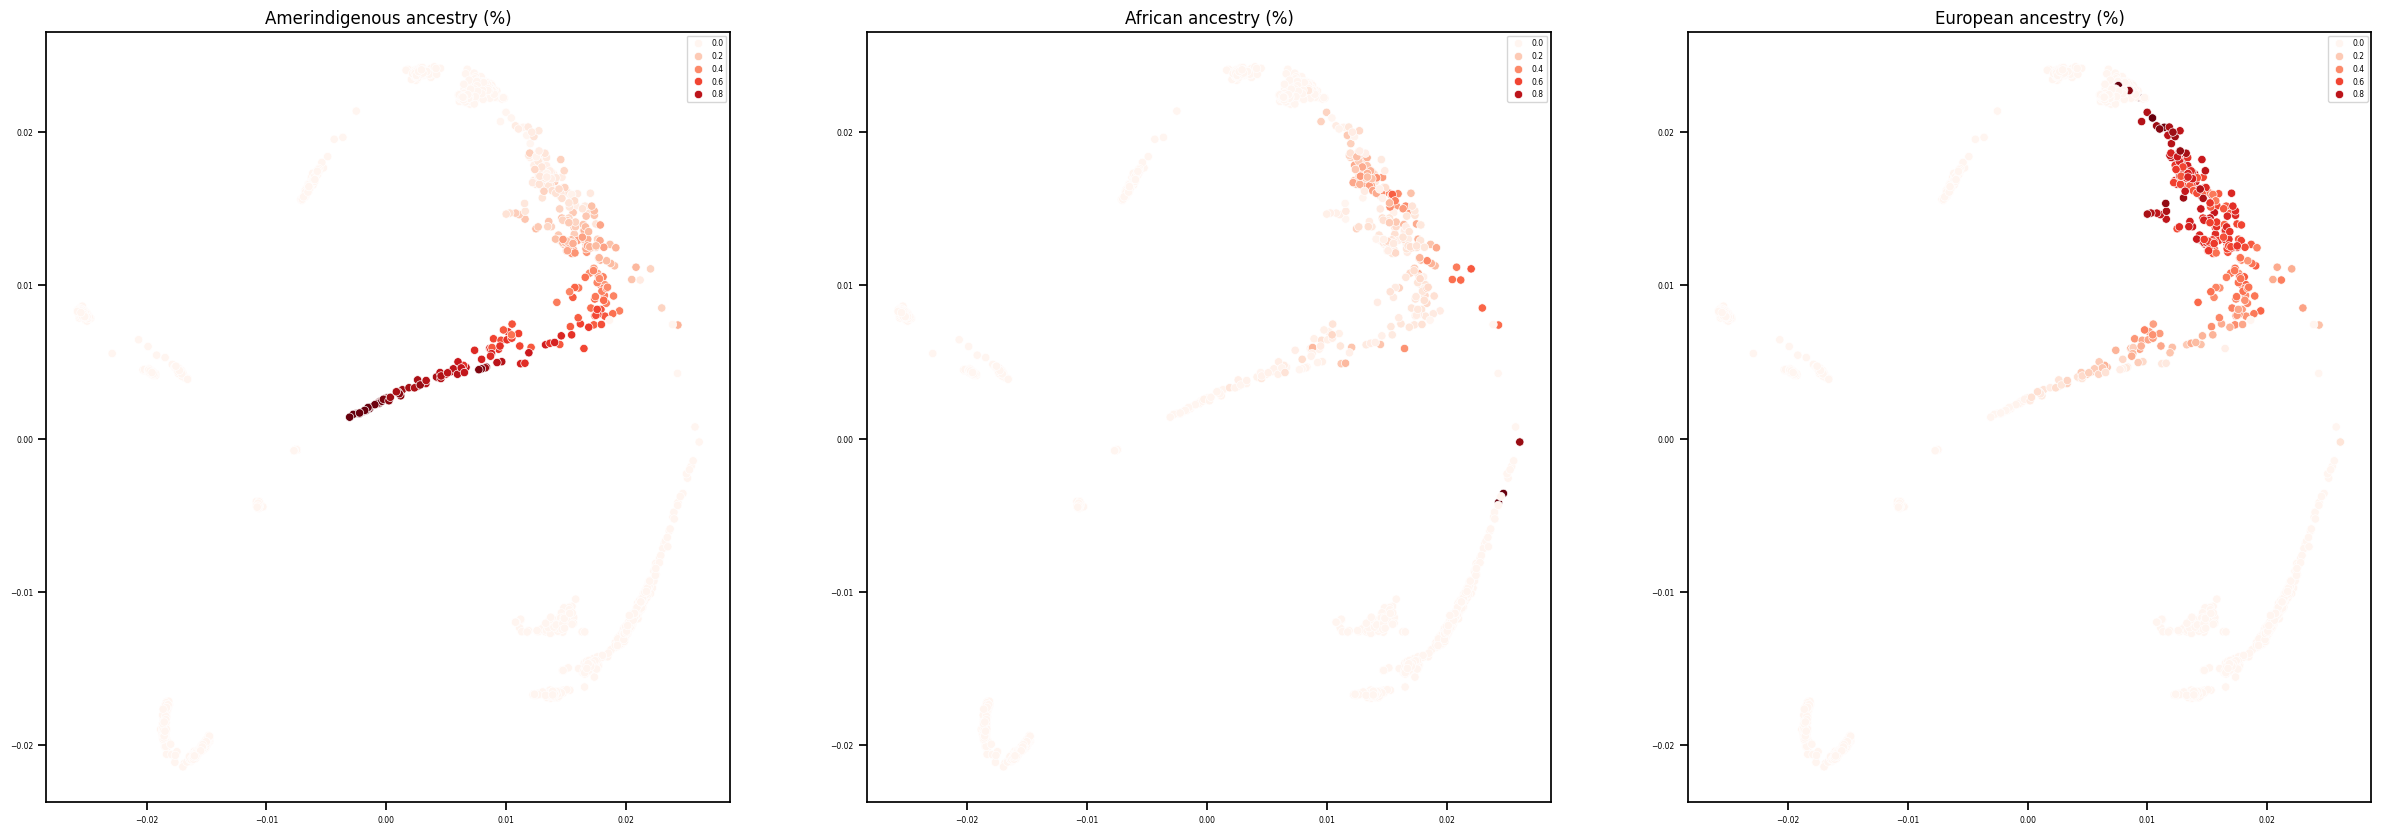

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))

sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels[:,0],
                palette='Reds',
                ax=ax[0])
ax[0].set_title("Amerindigenous ancestry (%)", fontsize=12)

sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels[:,1],
                palette='Reds',
                ax=ax[1])
ax[1].set_title("African ancestry (%)", fontsize=12)
sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels[:,2],
                palette='Reds',
                ax=ax[2])
ax[2].set_title("European ancestry (%)", fontsize=12)

Text(0.5, 1.0, 'European ancestry (%)')

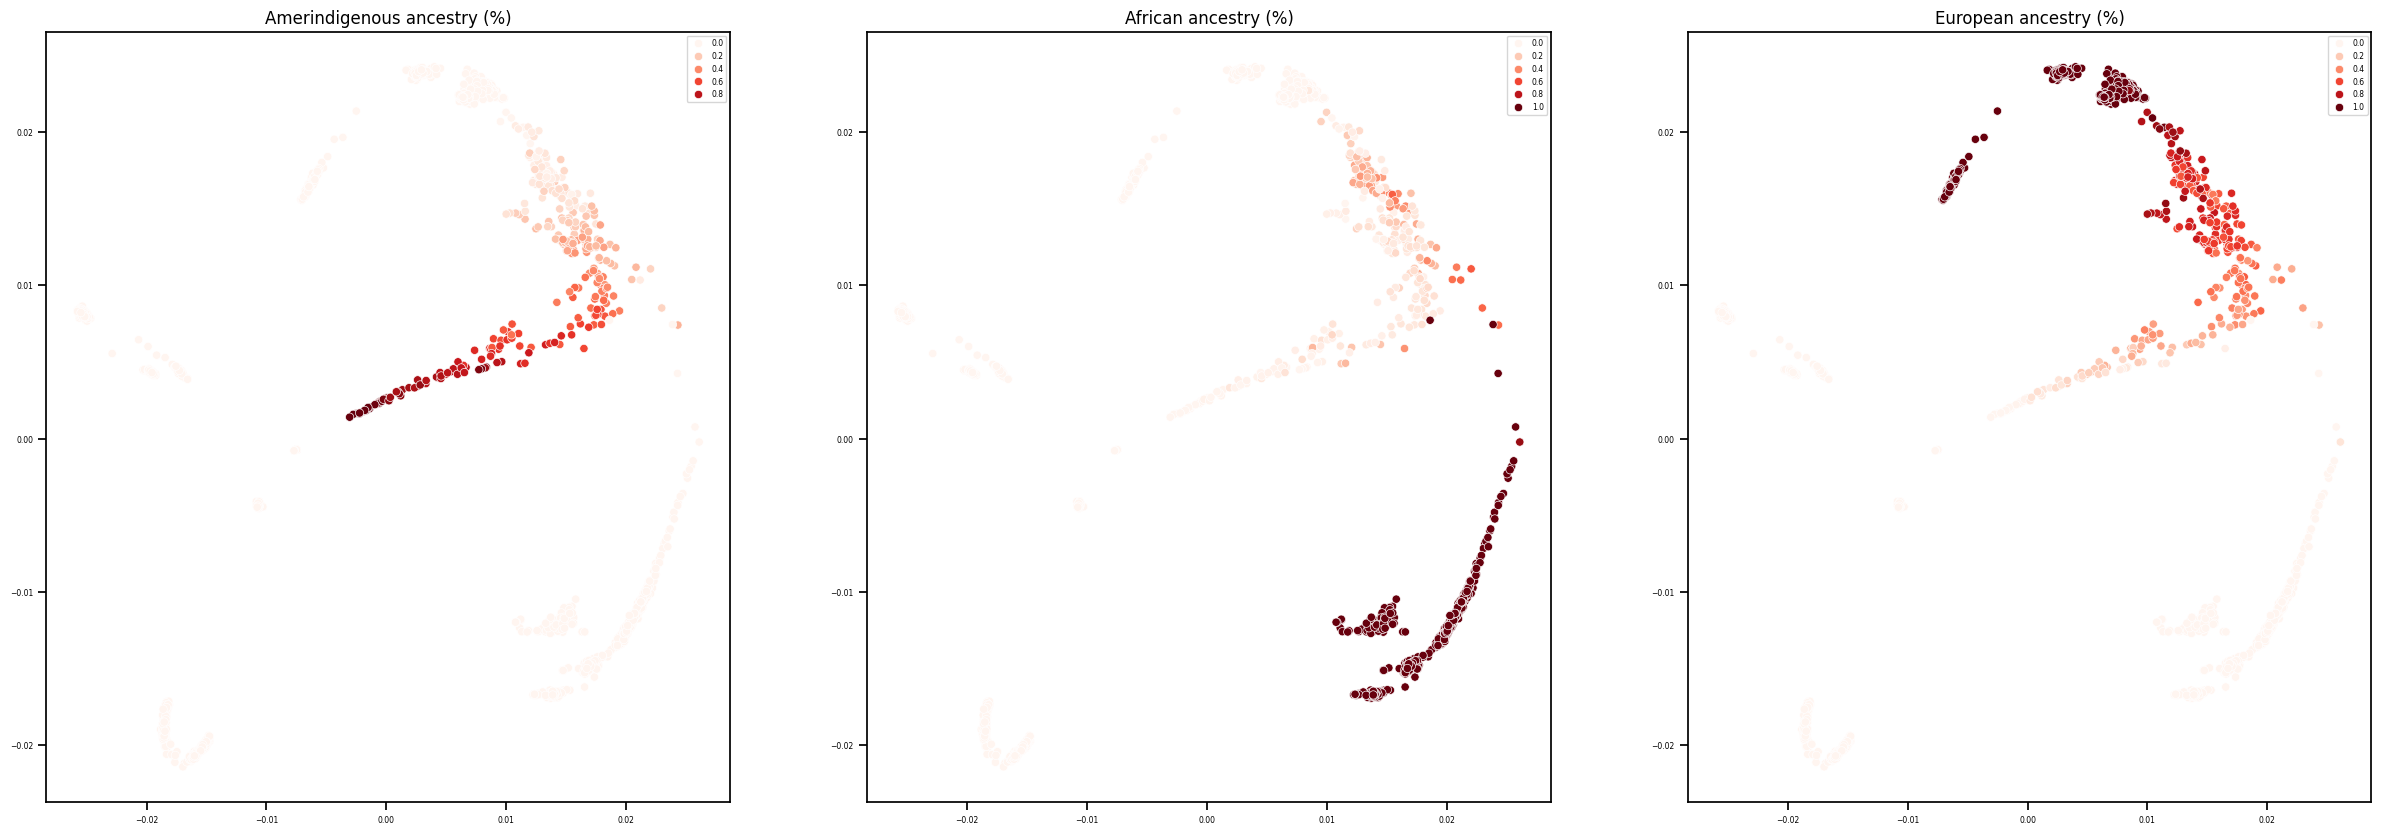

In [18]:
# adding
admix_labels2 = admix_labels
admix_labels2[label_with_superpop_names == 'EUR', 2] = 1
admix_labels2[label_with_superpop_names == 'AFR', 1] = 1

fig, ax = plt.subplots(ncols=3, figsize=(30,10))

sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels2[:,0],
                palette='Reds',
                ax=ax[0])
ax[0].set_title("Amerindigenous ancestry (%)", fontsize=12)

sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels2[:,1],
                palette='Reds',
                ax=ax[1])
ax[1].set_title("African ancestry (%)", fontsize=12)
sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels2[:,2],
                palette='Reds',
                ax=ax[2])
ax[2].set_title("European ancestry (%)", fontsize=12)

## My Admix Ratios

In [20]:
sample_ids = pd.read_csv('notebooks/MyAdmix/output_ids.txt', sep=' ', header=None)
admix_ratios = pd.read_csv('notebooks/MyAdmix/AMR_ACB_ASW.3.Q', sep=' ', header=None)

In [23]:
admix_labels_custom = np.zeros([len(label_with_names), 3])

In [24]:
admix_df = pd.concat([admix_ratios, sample_ids], axis=1)
admix_df.columns = ['admix 1', 'admix 2', 'admix 3' , 'sample id']

In [26]:
matching_indices = np.array([np.where(admix_df['sample id'][j] == labels2)[0][0] if len(np.where(admix_df['sample id'][j] == labels2)[0]) > 0 else -1 for j in range(len(admix_df))])

In [28]:
for i, idx in enumerate(matching_indices):
    if idx != -1:
        admix_labels_custom[idx] = admix_df.iloc[i].values[:3]

Text(0.5, 1.0, 'European ancestry (%)')

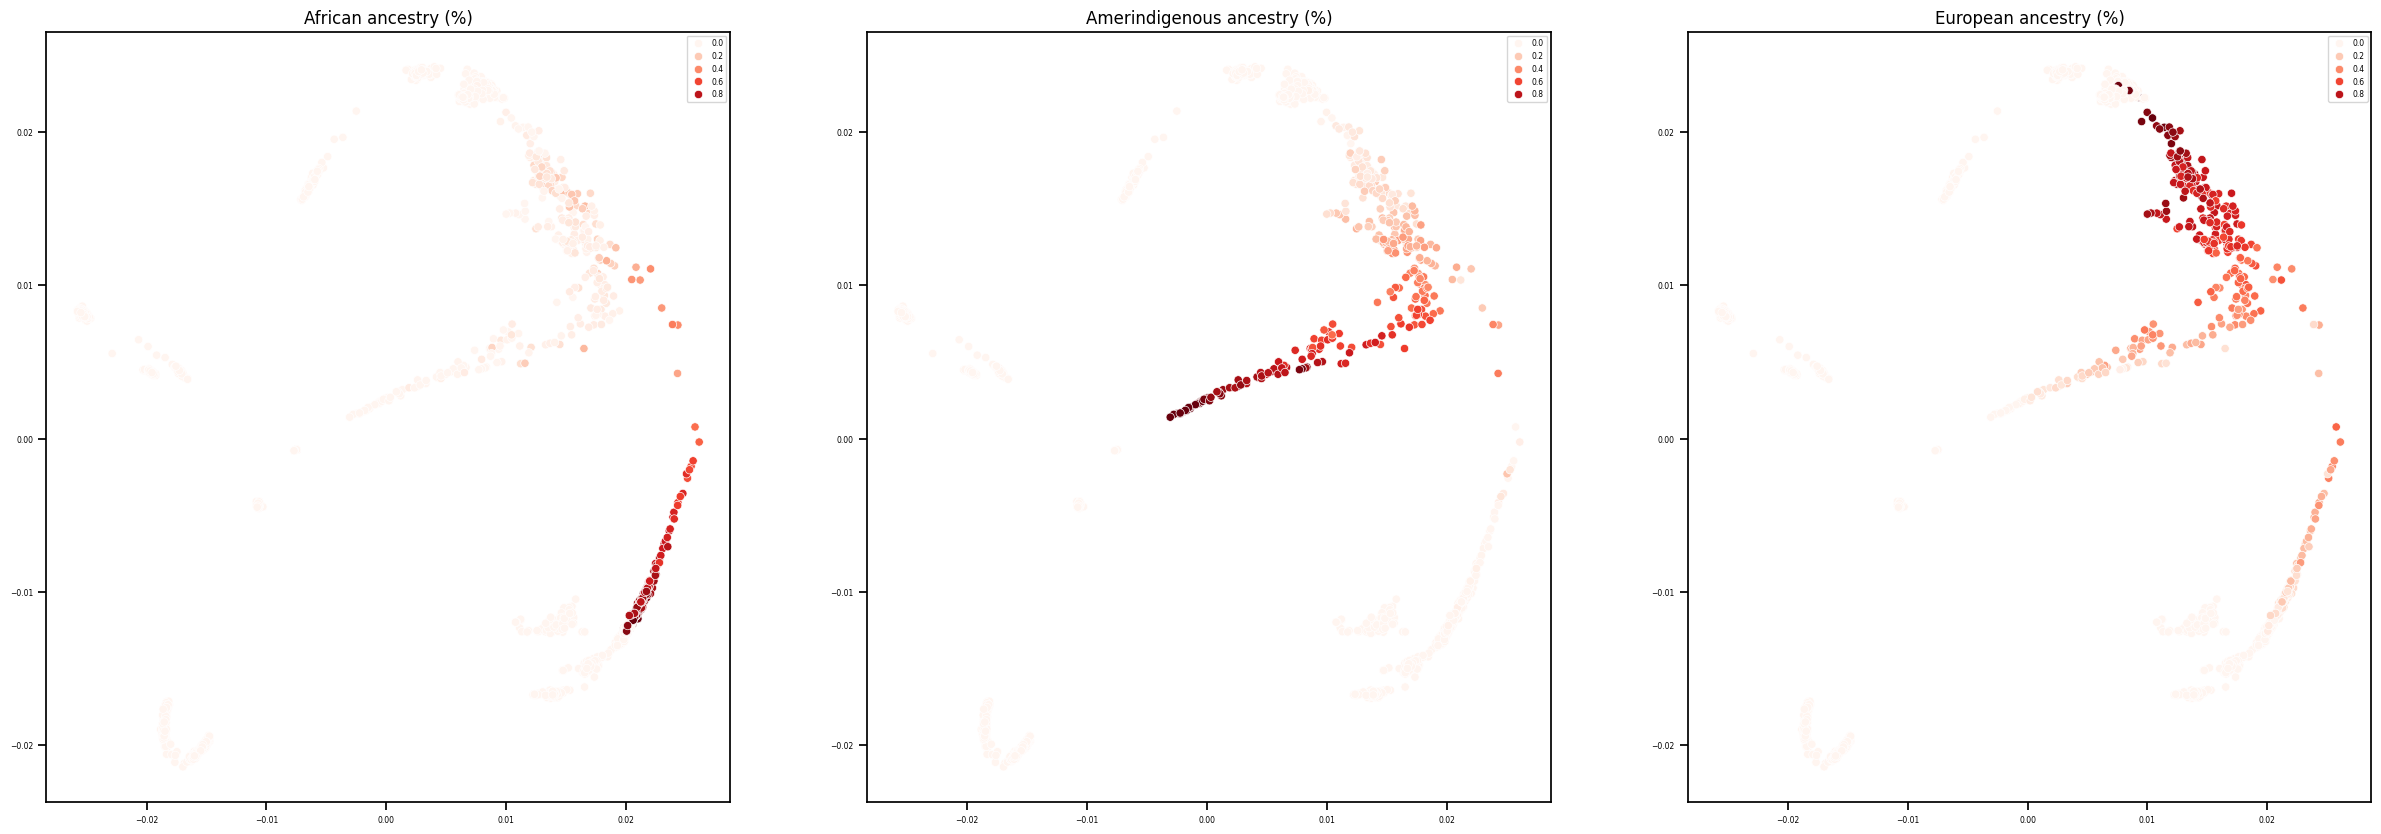

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))

sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels_custom[:,0],
                palette='Reds',
                ax=ax[0])
ax[0].set_title("African ancestry (%)", fontsize=12)

sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels_custom[:,1],
                palette='Reds',
                ax=ax[1])
ax[1].set_title("Amerindigenous ancestry (%)", fontsize=12)
sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels_custom[:,2],
                palette='Reds',
                ax=ax[2])
ax[2].set_title("European ancestry (%)", fontsize=12)

Text(0.5, 1.0, 'European ancestry (%)')

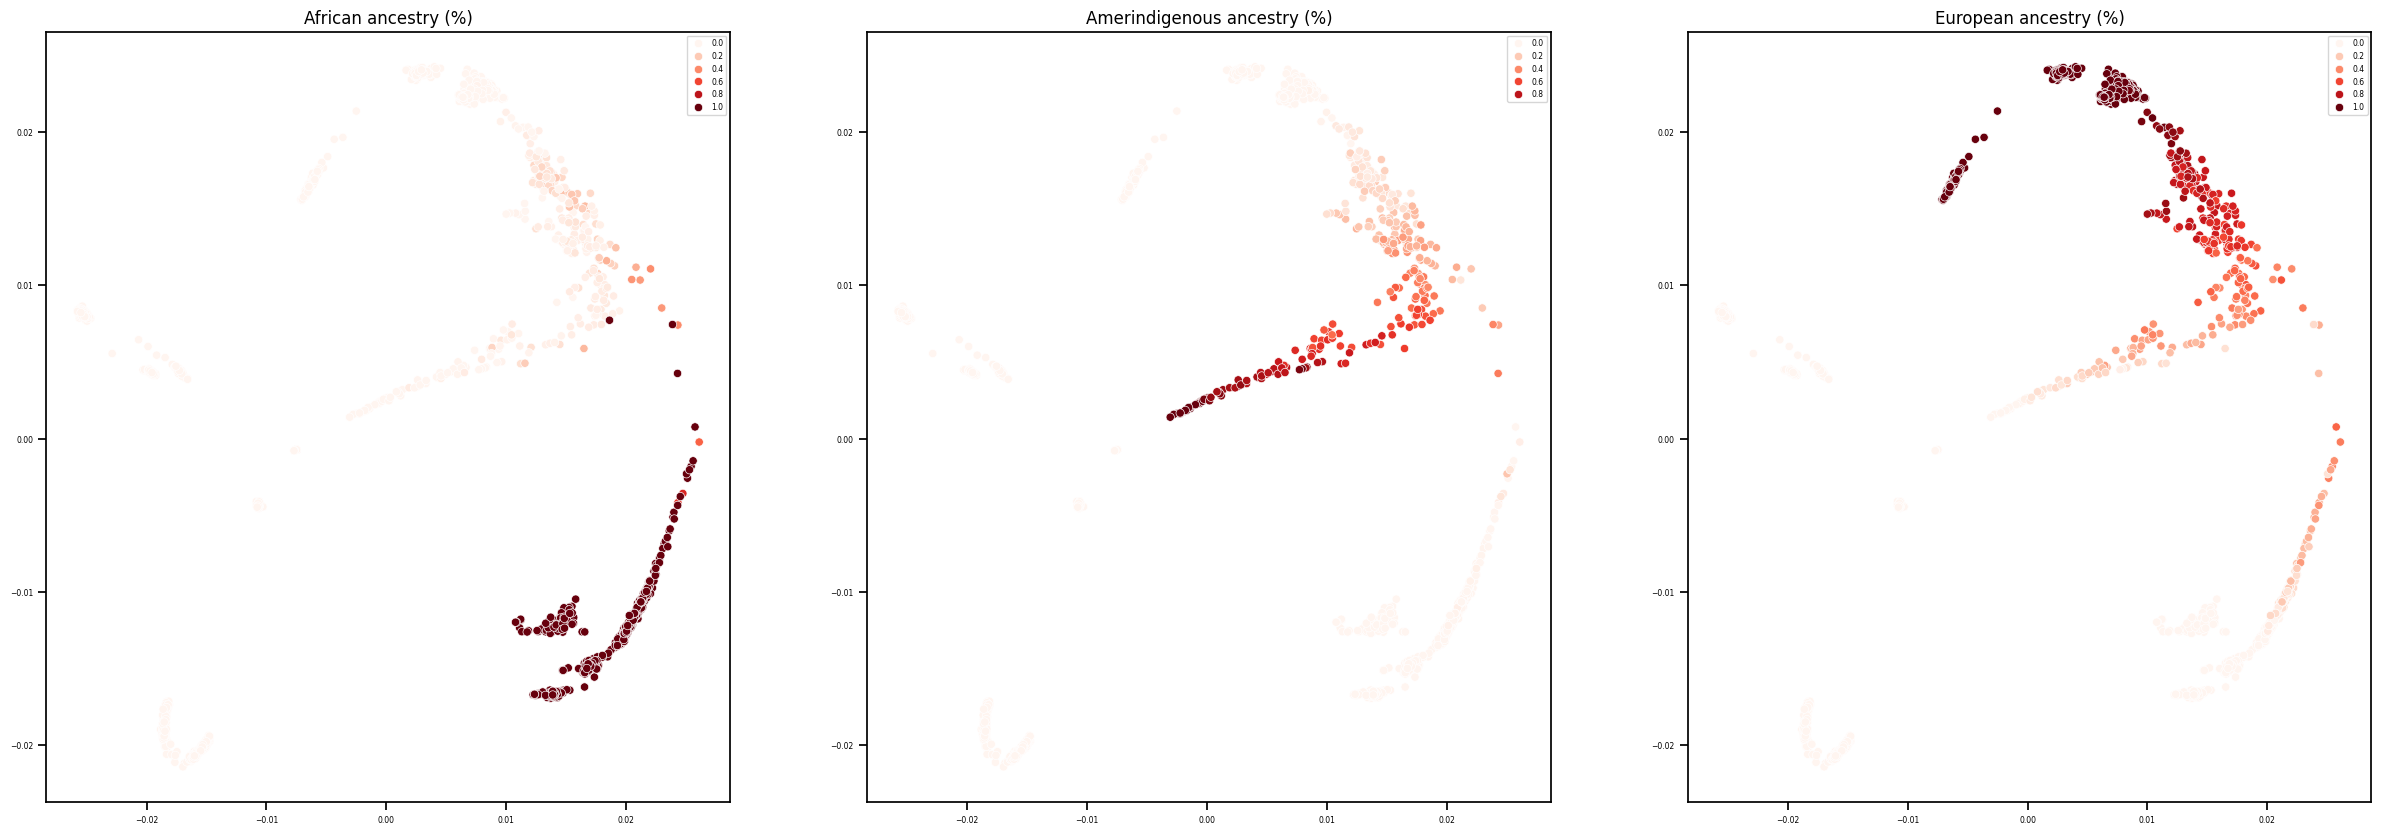

In [35]:
# adding EUR and AFR
admix_labels_custom2 = admix_labels_custom
admix_labels_custom2[label_with_superpop_names == 'EUR', 2] = 1
admix_labels_custom2[label_with_superpop_names == 'AFR', 0] = 1

fig, ax = plt.subplots(ncols=3, figsize=(30,10))

sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels_custom2[:,0],
                palette='Reds',
                ax=ax[0])
ax[0].set_title("African ancestry (%)", fontsize=12)

sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels_custom2[:,1],
                palette='Reds',
                ax=ax[1])
ax[1].set_title("Amerindigenous ancestry (%)", fontsize=12)
sns.scatterplot(x=phate_emb42[:,0],
                y=phate_emb42[:,1],
                hue=admix_labels_custom2[:,2],
                palette='Reds',
                ax=ax[2])
ax[2].set_title("European ancestry (%)", fontsize=12)

## Admixture Plot

In [48]:
order = np.argsort(np.array(label_with_names)[matching_indices])
pop_label_names_admix = np.array(label_with_names)[matching_indices][order]
admix_ratios_ordered = admix_ratios.loc[order]

In [70]:
cutoffs = []
labels_ordered = np.unique(pop_label_names_admix)

for label in labels_ordered:
    cutoffs.append(np.where(label == pop_label_names_admix)[0].min())
cutoffs += [len(pop_label_names_admix)]

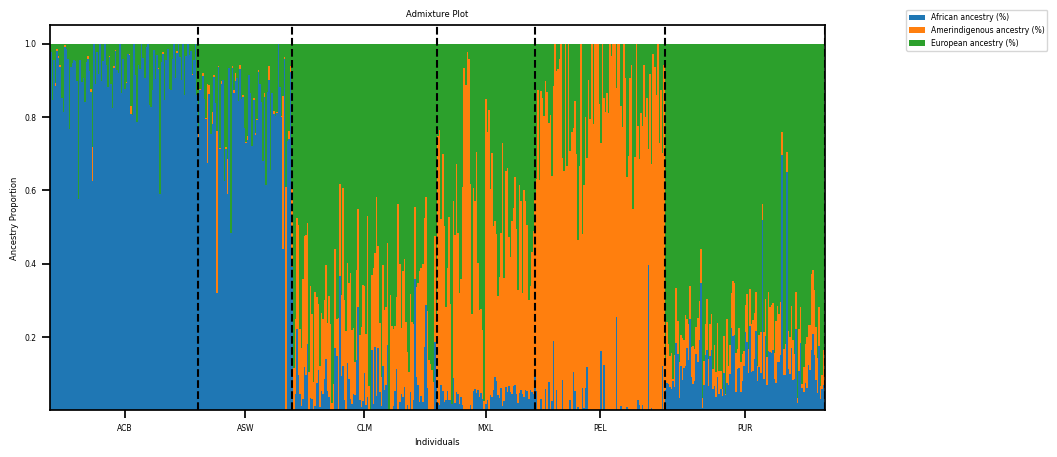

In [78]:
import matplotlib.pyplot as plt

# Assuming each column in your CSV represents an ancestry component
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the size as needed

# Plot each population/ancestry component in a stacked manner
admix_ratios_ordered.plot(kind='bar', stacked=True, ax=ax, width=1.0, edgecolor='none')

# Optional: Customize the axes and layout
ax.set_xlabel('Individuals')
ax.set_ylabel('Ancestry Proportion')
ax.set_title('Admixture Plot')
#ax.get_xaxis().set_visible(False)
plt.xticks(rotation=0)  # Rotate the x-axis labels to horizontal
ax.legend(title='Populations')

ax.legend(bbox_to_anchor=(1.1, 1.05), 
          loc='upper left',
          labels=["African ancestry (%)",
                  "Amerindigenous ancestry (%)",
                  "European ancestry (%)"])

for i, pos in enumerate(cutoffs[1:]):
    ax.axvline(x=pos, linestyle='--', color='black')

plt.xticks(ticks=[(cutoffs[i]+cutoffs[i+1])/2 for i in range(len(cutoffs)-1)], labels=labels_ordered)

# Show the plot
plt.show()